In [93]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2 as cv

from skimage.feature import hog 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import os
import shutil as sh

sns.set_theme(style="darkgrid")

## Modèle 1 : 4 classes

### Préparation du jeux de données

In [79]:
def create_dataset1(source_dir, dest_dir) :
    myfolder = os.listdir(source_dir)
    for folder in myfolder : 
        path2 = os.path.join(source_dir,folder)
        classes = os.listdir(path2)
        for classe in classes : 
            path3 = os.path.join(path2,classe)
            myimages = os.listdir(path3)
            myclass = source_dir+"_"+classe
            for image in myimages : 
                all_path = os.path.join(path3,image)
                path_dest1 = os.path.join(dest_dir,folder)
                path_dest_final = os.path.join(path_dest1,myclass)
                if not os.path.isdir(path_dest_final) : 
                    os.makedirs(path_dest_final) # si il n'existe pas il le crée
                sh.copy(all_path, path_dest_final)

In [80]:
spiral_path = "spiral"
wave_path = "wave"
dest_path = "Dataset1"
create_dataset1(spiral_path,dest_path)
create_dataset1(wave_path,dest_path)

### Chargement et binarisation des images

In [84]:
def loadimages(source_dir) :
    myimages = list()
    mylabels = list()
    myclasses = os.listdir(source_dir)
    for classe in myclasses :
        mypath = os.path.join(source_dir,classe)
        mesimages = os.listdir(mypath)
        images_path = [os.path.join(mypath,x) for x in mesimages]
        for path in images_path :
            test_image = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2GRAY)
            histo_test = cv.calcHist([test_image], channels=[0], mask=None,histSize=[256], ranges=[0, 256])
            hist_argmax = histo_test.argmax()
            test_image2 = test_image.copy()
            test_image_filtre1 = test_image2>hist_argmax-30
            test_image_filtre2 = test_image2<=hist_argmax-30
            test_image[~test_image_filtre1] = 0
            test_image[~test_image_filtre2] = 255
            myimages.append(test_image)
            mylabels.append(classe)
    return myimages, mylabels

In [85]:
train_path = "./Dataset1/training/"
test_path = "./Dataset1/testing/"
train_images, train_labels = loadimages(train_path)
test_images, test_labels = loadimages(test_path)

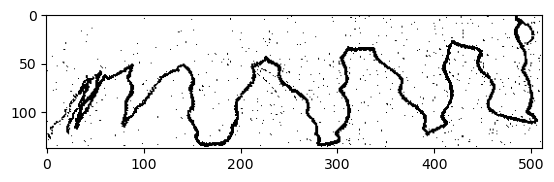

In [92]:
plt.imshow(train_images[140], cmap="gray")
plt.show()

### HoG

In [94]:
def hog_list (listimage) :
    fv = []
    hog_image = []
    for i in range(len(listimage)) :
        a, b = hog(listimage[i], orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True)
        fv.append(a)
        hog_image.append(b)
    return fv,hog_image

In [95]:
features_train, hog_images_train = hog_list(train_images)
features_test, hog_images_test = hog_list(test_images)

### Classifieur

In [97]:
train_images[120].shape

(194, 512)